In [ ]:
!pip install -q imbalanced-learn


Distribution: Counter({np.int64(0): 250, np.int64(6): 250, np.int64(1): 200, np.int64(2): 200, np.int64(4): 200, np.int64(5): 150, np.int64(3): 150})


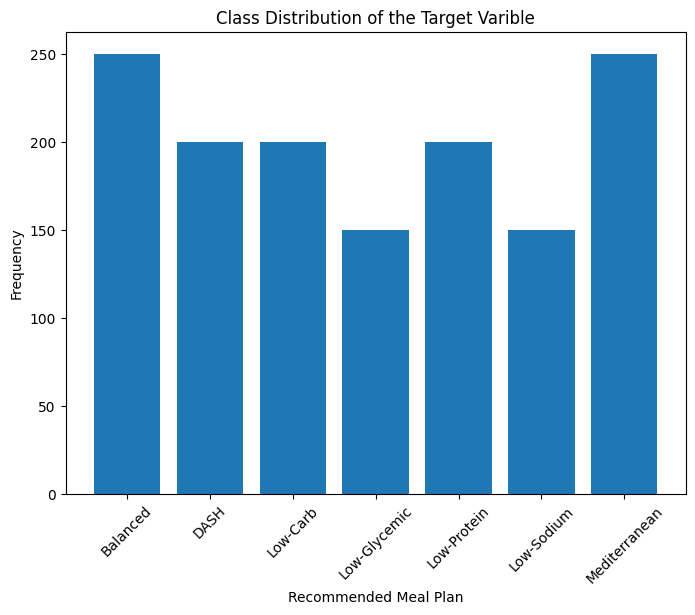

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# ============================
# 1. Cargar datos
# ============================
df = pd.read_csv("Generated_Medical_Diet_Dataset.csv")

# Codificar la variable objetivo
le_target = LabelEncoder()
y = le_target.fit_transform(df["Recommended_Meal_Plan_Medical"])
joblib.dump(le_target, "label_encoder_target.pkl")

X = df.drop(columns=["Recommended_Meal_Plan_Medical"])
X = pd.DataFrame(SimpleImputer(strategy="mean").fit_transform(X), columns=X.columns)

# Distribución
print("Distribution:", Counter(y))
plt.figure(figsize=(8, 6))
plt.bar(Counter(y).keys(), Counter(y).values())
plt.xticks(ticks=range(len(le_target.classes_)), labels=le_target.classes_, rotation=45)
plt.title('Class Distribution of the Target Varible')
plt.xlabel('Recommended Meal Plan')
plt.ylabel('Frequency')
plt.show()



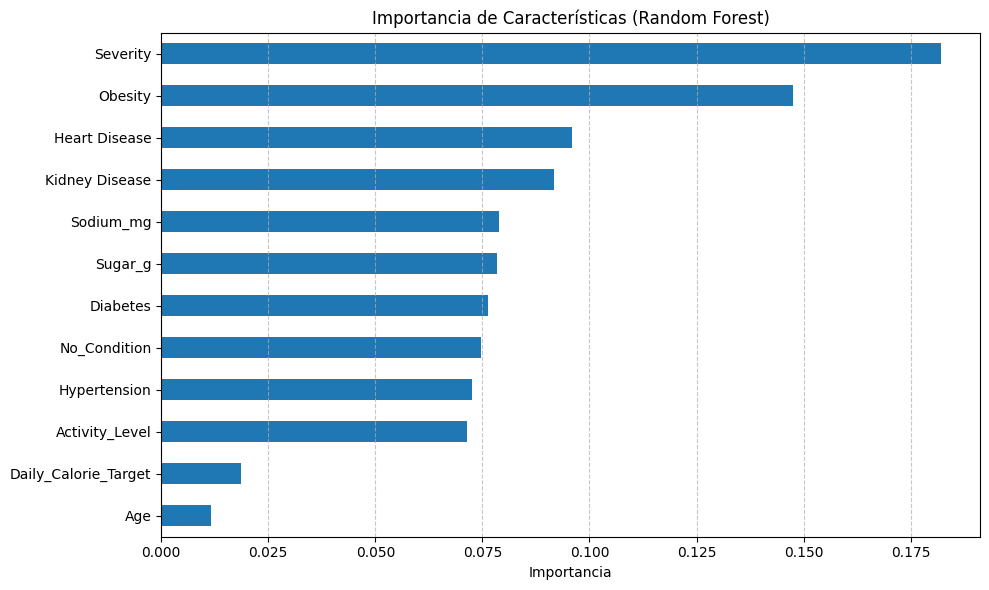

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier



# ============================
# 5. Entrenar modelo Random Forest
# ============================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# ============================
# 6. Importancia de características
# ============================
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

# ============================
# 7. Visualización del ranking
# ============================
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', title="Importancia de Características (Random Forest)")
plt.xlabel("Importancia")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

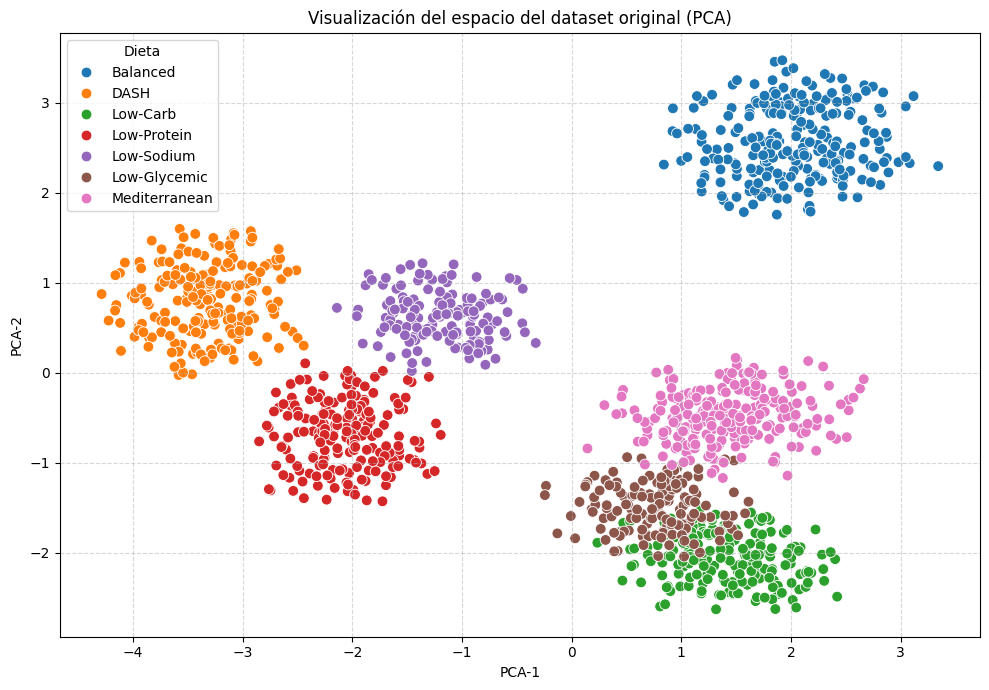

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Separar características y etiquetas
X = df.drop(columns=["Recommended_Meal_Plan_Medical"])
y = df["Recommended_Meal_Plan_Medical"]

# Escalar los datos
X_scaled = StandardScaler().fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización
pca_df = pd.DataFrame(X_pca, columns=["PCA-1", "PCA-2"])
pca_df["Dieta"] = y

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PCA-1", y="PCA-2", hue="Dieta", palette="tab10", s=60)
plt.title("Visualización del espacio del dataset original (PCA)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



Fitting 5 folds for each of 45 candidates, totalling 225 fits
🔍 Decision Tree - Mejor configuración: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
               precision    recall  f1-score   support

     Balanced       1.00      1.00      1.00        50
         DASH       1.00      1.00      1.00        40
     Low-Carb       0.87      1.00      0.93        40
 Low-Glycemic       1.00      0.80      0.89        30
  Low-Protein       1.00      1.00      1.00        40
   Low-Sodium       1.00      1.00      1.00        30
Mediterranean       1.00      1.00      1.00        50

     accuracy                           0.98       280
    macro avg       0.98      0.97      0.97       280
 weighted avg       0.98      0.98      0.98       280



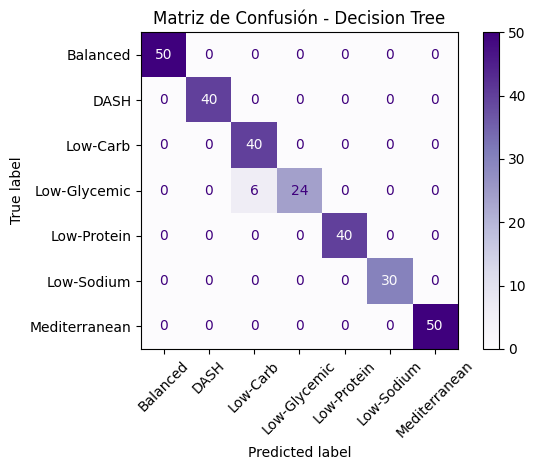

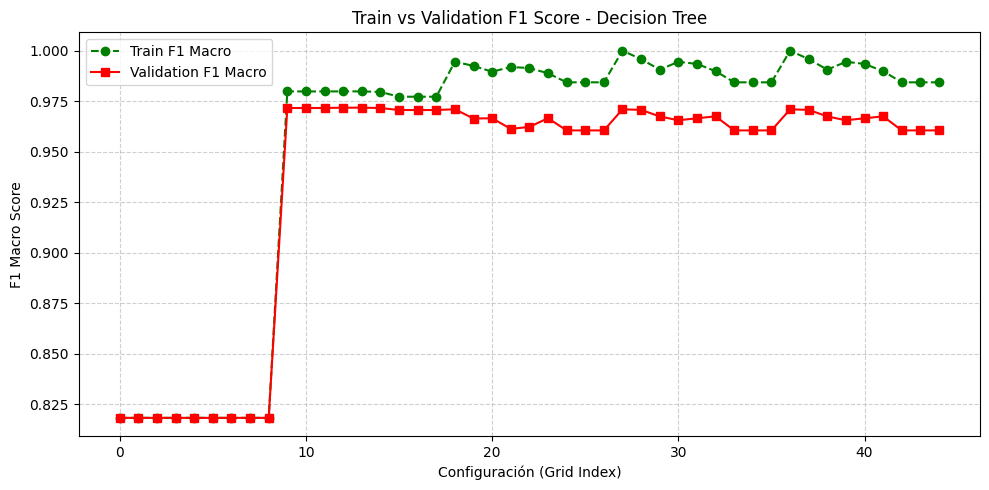

In [10]:
# ============================
# DECISION TREE
# ============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# ============================
# 2. Split de entrenamiento
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================
# 3. Entrenar modelo Decision Tree
# ============================
param_dt = {
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_dt,
    cv=5,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

# ============================
# 4. Evaluación
# ============================
y_pred_dt = best_dt.predict(X_test)
print("🔍 Decision Tree - Mejor configuración:", grid_dt.best_params_)
print(classification_report(y_test, y_pred_dt, target_names=le_target.classes_))

ConfusionMatrixDisplay.from_estimator(
    best_dt, X_test, y_test,
    display_labels=le_target.classes_,
    cmap="Purples"
)
plt.title("Matriz de Confusión - Decision Tree")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================
# 5. Curva Train vs Validation
# ============================
results_dt = pd.DataFrame(grid_dt.cv_results_)

plt.figure(figsize=(10, 5))
plt.plot(results_dt["mean_train_score"], label="Train F1 Macro", linestyle="--", marker='o', color='green')
plt.plot(results_dt["mean_test_score"], label="Validation F1 Macro", linestyle="-", marker='s', color='red')
plt.xlabel("Configuración (Grid Index)")
plt.ylabel("F1 Macro Score")
plt.title("Train vs Validation F1 Score - Decision Tree")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# ============================
# 6. Mostrar último valor de F1 Macro (Train y Validation)
# ============================
last_index = results_dt.index[-1]
last_train_score = results_dt.loc[last_index, "mean_train_score"]
last_val_score = results_dt.loc[last_index, "mean_test_score"]

print(f"📈 Último valor de F1 Macro (Train): {last_train_score:.4f}")
print(f"📊 Último valor de F1 Macro (Validation): {last_val_score:.4f}")

📈 Último valor de F1 Macro (Train): 0.9843
📊 Último valor de F1 Macro (Validation): 0.9605


Fitting 5 folds for each of 108 candidates, totalling 540 fits
🔍 Random Forest - Mejor configuración: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
               precision    recall  f1-score   support

     Balanced       1.00      1.00      1.00        50
         DASH       1.00      1.00      1.00        40
     Low-Carb       0.89      1.00      0.94        40
 Low-Glycemic       1.00      0.83      0.91        30
  Low-Protein       1.00      1.00      1.00        40
   Low-Sodium       1.00      1.00      1.00        30
Mediterranean       1.00      1.00      1.00        50

     accuracy                           0.98       280
    macro avg       0.98      0.98      0.98       280
 weighted avg       0.98      0.98      0.98       280



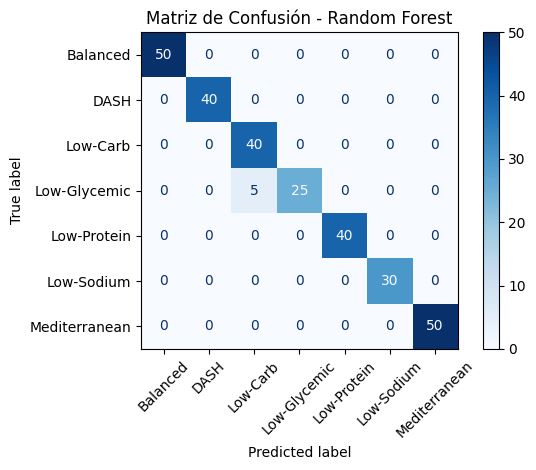

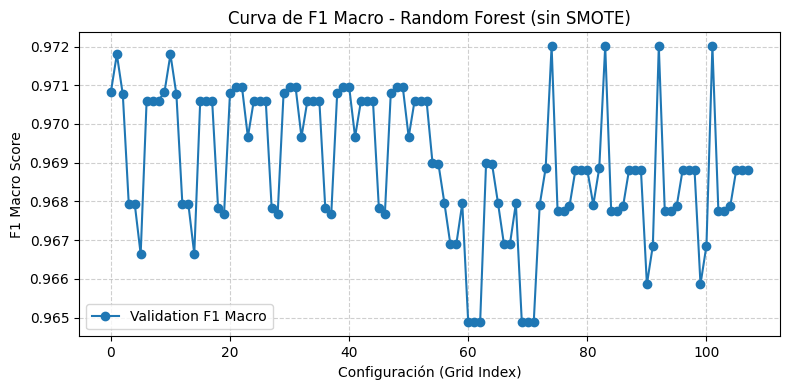

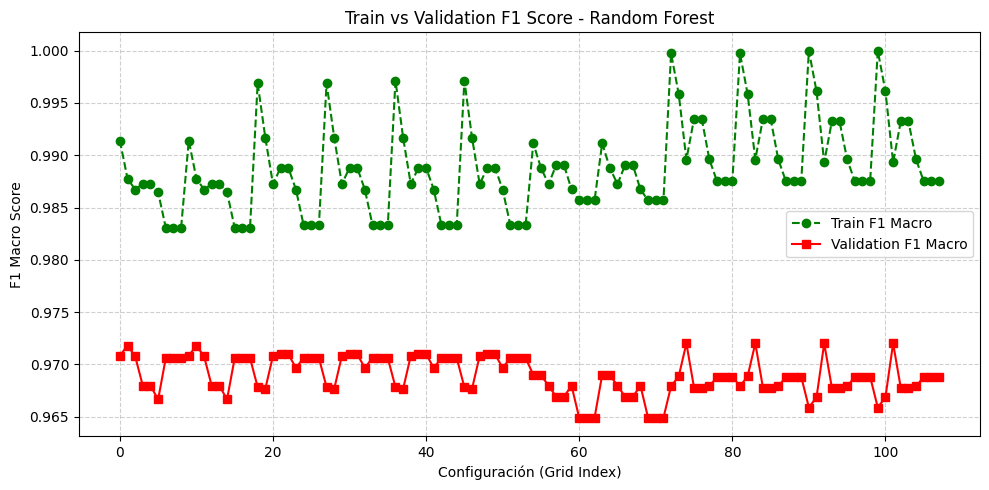

In [11]:
# ============================
# RANDOM FOREST SIN SMOTE
# ============================

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# ============================
# 2. División train/test
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================
# 3. GridSearchCV para Random Forest
# ============================
param_rf = {
    "n_estimators": [100],
    "max_depth": [10, 15, 20],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 5, 10],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_rf,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
joblib.dump(best_rf, "best_random_forest_model_no_smote.pkl")

# ============================
# 4. Predicción y resultados
# ============================
y_pred_rf = best_rf.predict(X_test)

print("🔍 Random Forest - Mejor configuración:", grid_rf.best_params_)
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=le_target.classes_,
    cmap="Blues"
)
plt.title("Matriz de Confusión - Random Forest")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================
# 5. Curva de F1 Macro
# ============================
results_rf = pd.DataFrame(grid_rf.cv_results_)

plt.figure(figsize=(8, 4))
plt.plot(results_rf["mean_test_score"], label="Validation F1 Macro", marker='o')
plt.xlabel("Configuración (Grid Index)")
plt.ylabel("F1 Macro Score")
plt.title("Curva de F1 Macro - Random Forest (sin SMOTE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 6. Train vs Validation Accuracy
# ============================
plt.figure(figsize=(10, 5))
plt.plot(results_rf["mean_train_score"], label="Train F1 Macro", linestyle="--", marker='o', color='green')
plt.plot(results_rf["mean_test_score"], label="Validation F1 Macro", linestyle="-", marker='s', color='red')
plt.xlabel("Configuración (Grid Index)")
plt.ylabel("F1 Macro Score")
plt.title("Train vs Validation F1 Score - Random Forest")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [12]:
# ============================
# 7. Mostrar último valor de F1 Macro (Train y Validation)
# ============================
last_index = results_rf.index[-1]
last_train_score = results_rf.loc[last_index, "mean_train_score"]
last_val_score = results_rf.loc[last_index, "mean_test_score"]

print(f"📈 Último valor de F1 Macro (Train): {last_train_score:.4f}")
print(f"📊 Último valor de F1 Macro (Validation): {last_val_score:.4f}")

📈 Último valor de F1 Macro (Train): 0.9875
📊 Último valor de F1 Macro (Validation): 0.9688


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.1720 - loss: 2.9029 - val_accuracy: 0.2991 - val_loss: 1.9334 - learning_rate: 1.0000e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2568 - loss: 2.4239 - val_accuracy: 0.4732 - val_loss: 1.8084 - learning_rate: 1.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2985 - loss: 2.2544 - val_accuracy: 0.6161 - val_loss: 1.6662 - learning_rate: 1.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4271 - loss: 1.7690 - val_accuracy: 0.6830 - val_loss: 1.5098 - learning_rate: 1.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4657 - loss: 1.5892 - val_accuracy: 0.7723 - val_loss: 1.3431 - learning_rate: 1.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5418 - loss: 1.4011 - val_accuracy: 0.8170 - val_loss: 1.1772 - learning_rate: 1.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5

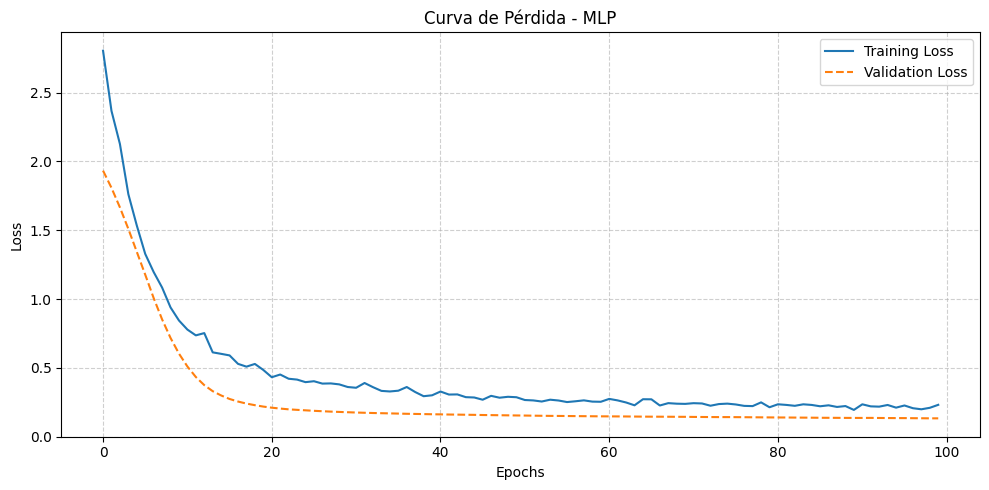

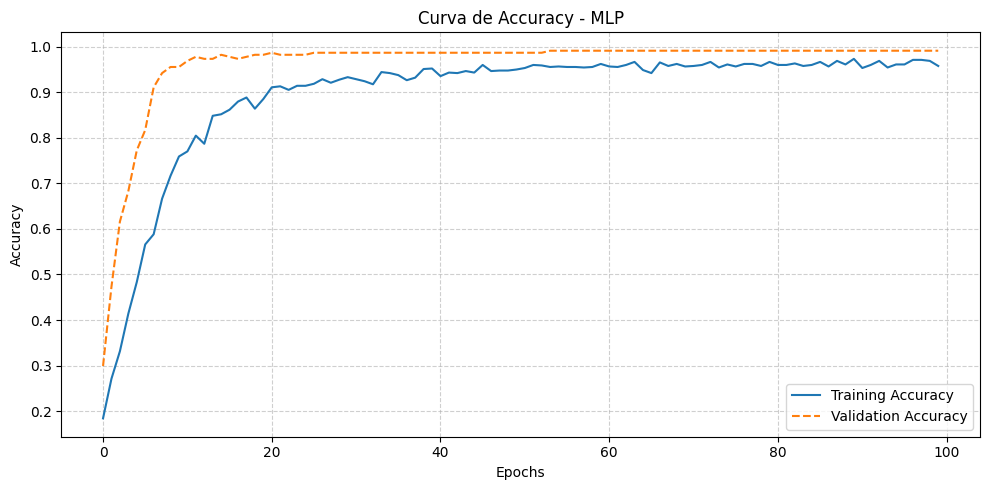

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
🔍 Reporte de Clasificación (Test):
               precision    recall  f1-score   support

     Balanced       1.00      1.00      1.00        50
         DASH       1.00      1.00      1.00        40
     Low-Carb       0.95      0.97      0.96        40
 Low-Glycemic       0.97      0.93      0.95        30
  Low-Protein       1.00      1.00      1.00        40
   Low-Sodium       1.00      1.00      1.00        30
Mediterranean       1.00      1.00      1.00        50

     accuracy                           0.99       280
    macro avg       0.99      0.99      0.99       280
 weighted avg       0.99      0.99      0.99       280



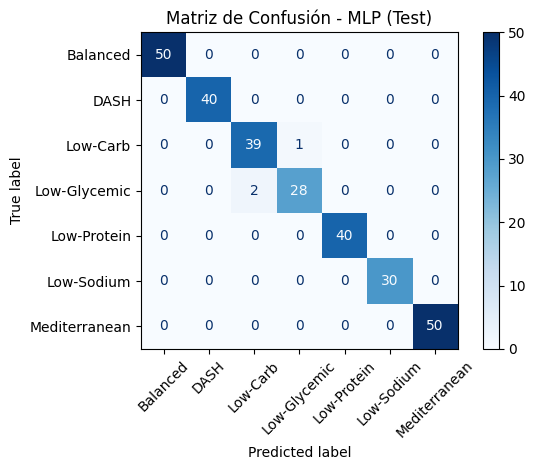

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, regularizers

# ============================
# 1. Cargar y preparar datos
# ============================
df = pd.read_csv("Generated_Medical_Diet_Dataset.csv")

# Codificar variable objetivo
le_target = LabelEncoder()
y = le_target.fit_transform(df["Recommended_Meal_Plan_Medical"])
joblib.dump(le_target, "label_encoder_target.pkl")

X = df.drop(columns=["Recommended_Meal_Plan_Medical"])
categorical_cols = X.select_dtypes(include="object").columns
X[categorical_cols] = OrdinalEncoder().fit_transform(X[categorical_cols])
X = pd.DataFrame(SimpleImputer(strategy="mean").fit_transform(X), columns=X.columns)

# ============================
# 2. División 80% entrenamiento / 20% test
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================
# 3. Modelo MLP Regularizado
# ============================
n_classes = len(np.unique(y))
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.GaussianNoise(0.1),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================
# 4. Callbacks
# ============================
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# ============================
# 5. Class Weights
# ============================
class_weights = dict(
    zip(
        np.unique(y_train),
        compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    )
)

# ============================
# 6. Entrenamiento (con validación interna del 20%)
# ============================
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

# ============================
# 7. Curvas de entrenamiento
# ============================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Curva de Pérdida - MLP")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Curva de Accuracy - MLP")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ============================
# 8. Evaluación en test
# ============================
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("🔍 Reporte de Clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=le_target.classes_,
    cmap="Blues"
)
plt.title("Matriz de Confusión - MLP (Test)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🎯 Features seleccionadas: ['Activity_Level', 'Sodium_mg', 'Sugar_g', 'Severity', 'Diabetes', 'Obesity', 'Heart Disease', 'Hypertension', 'Kidney Disease', 'No_Condition']
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2111 - loss: 2.7300 - val_accuracy: 0.8839 - val_loss: 1.5560 - learning_rate: 5.0000e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6697 - loss: 1.0031 - val_accuracy: 0.9241 - val_loss: 1.1796 - learning_rate: 5.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8694 - loss: 0.5716 - val_accuracy: 0.9375 - val_loss: 0.9265 - learning_rate: 5.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9106 - loss: 0.4222 - val_accuracy: 0.9598 - val_loss: 0.7420 - learning_rate: 5.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9250 - loss: 0.3705 - val_accuracy: 0.9777 - val_loss: 0.5916 - learning_rate: 5.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

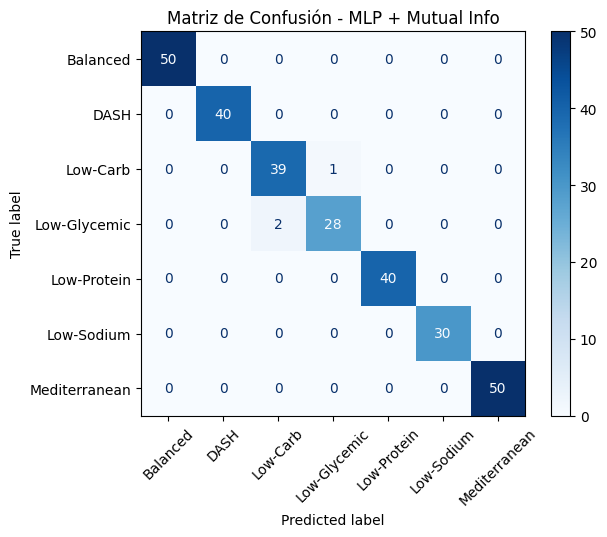

               precision    recall  f1-score   support

     Balanced       1.00      1.00      1.00        50
         DASH       1.00      1.00      1.00        40
     Low-Carb       0.95      0.97      0.96        40
 Low-Glycemic       0.97      0.93      0.95        30
  Low-Protein       1.00      1.00      1.00        40
   Low-Sodium       1.00      1.00      1.00        30
Mediterranean       1.00      1.00      1.00        50

     accuracy                           0.99       280
    macro avg       0.99      0.99      0.99       280
 weighted avg       0.99      0.99      0.99       280



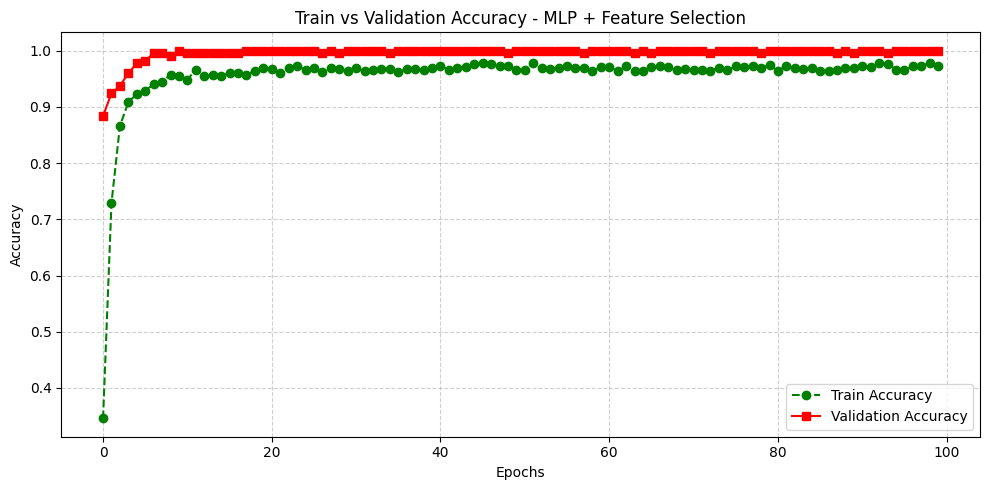

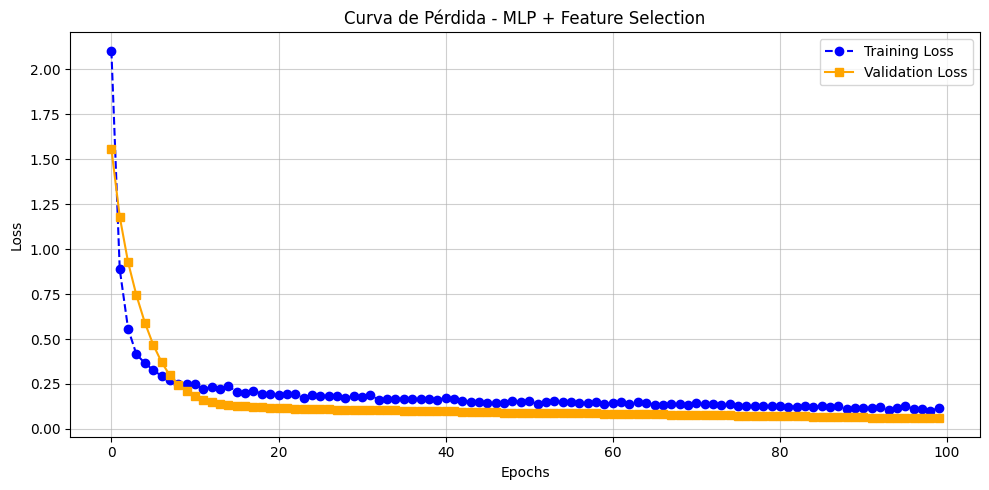

✅ Modelo MLP guardado como 'mlp_mutual_info_model.keras'
✅ Scaler guardado como 'scaler_mutual_info.pkl'
✅ Features seleccionadas guardadas como 'selected_features_mutual_info.pkl'
✅ Label encoder guardado como 'label_encoder_target.pkl'


In [6]:
# ============================
# MLP + Mutual Info Feature Selection
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, regularizers

# ============================
# 1. Cargar y preparar datos
# ============================
le_target = LabelEncoder()
y = le_target.fit_transform(df["Recommended_Meal_Plan_Medical"])
joblib.dump(le_target, "label_encoder_target.pkl")

X = df.drop(columns=["Recommended_Meal_Plan_Medical"])
categorical_cols = X.select_dtypes(include="object").columns
X[categorical_cols] = OrdinalEncoder().fit_transform(X[categorical_cols])
X = pd.DataFrame(SimpleImputer(strategy="mean").fit_transform(X), columns=X.columns)

# ============================
# 2. Feature selection
# ============================
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("🎯 Features seleccionadas:", list(selected_features))

# ============================
# 3. División y Escalamiento
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================
# 4. Modelo MLP
# ============================
n_classes = len(np.unique(y))
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================
# 5. Callbacks
# ============================
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# ============================
# 6. Entrenamiento
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

# ============================
# 7. Evaluación
# ============================
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le_target.classes_,
    cmap="Blues"
)
plt.title("Matriz de Confusión - MLP + Mutual Info")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# ============================
# 8. Curvas de entrenamiento
# ============================
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', marker='o', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='s', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy - MLP + Feature Selection")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 9. Curva de Pérdida (Loss)
# ============================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='s', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Curva de Pérdida - MLP + Feature Selection")
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Guardar el modelo MLP
model.save("mlp_mutual_info_model.keras")
print("✅ Modelo MLP guardado como 'mlp_mutual_info_model.keras'")

# Guardar el scaler
joblib.dump(scaler, "scaler_mutual_info.pkl")
print("✅ Scaler guardado como 'scaler_mutual_info.pkl'")

# Guardar las features seleccionadas
joblib.dump(selected_features, "selected_features_mutual_info.pkl")
print("✅ Features seleccionadas guardadas como 'selected_features_mutual_info.pkl'")

# Guardar el label encoder
joblib.dump(le_target, "label_encoder_target.pkl")
print("✅ Label encoder guardado como 'label_encoder_target.pkl'")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 Distribución de predicciones (1000 pacientes simulados):

               Frecuencia  Porcentaje
Balanced              103        10.3
DASH                  342        34.2
Low-Carb               13         1.3
Low-Glycemic           76         7.6
Low-Protein           132        13.2
Low-Sodium             64         6.4
Mediterranean         270        27.0


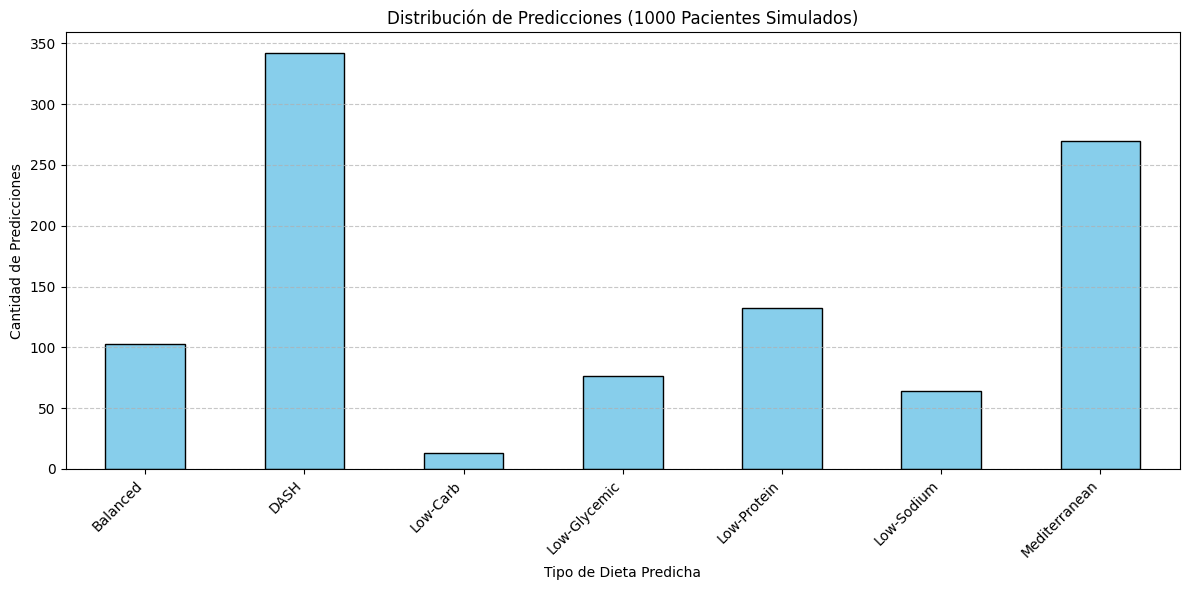

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# ============================
# 1. Cargar modelo y recursos
# ============================
model = tf.keras.models.load_model("mlp_mutual_info_model.keras")
selected_features = joblib.load("selected_features_mutual_info.pkl")
label_encoder = joblib.load("label_encoder_target.pkl")
scaler = joblib.load("scaler_mutual_info.pkl")

# ============================
# 2. Simulación de pacientes
# ============================


# Simular condiciones médicas
simulated_data = pd.DataFrame({
    "Activity_Level": np.random.randint(0, 5, 1000),
    "Sodium_mg": np.random.uniform(500, 2500, 1000),
    "Sugar_g": np.random.uniform(5, 60, 1000),
    "Severity": np.random.choice([0, 1, 2], size=1000),  # Más real: mayoría leves
    "Diabetes": np.random.randint(0, 2, 1000),
    "Obesity": np.random.randint(0, 2, 1000),
    "Heart Disease": np.random.randint(0, 2, 1000),
    "Hypertension": np.random.randint(0, 2, 1000),
    "Kidney Disease": np.random.randint(0, 2, 1000),
})

# Corregir No_Condition
conditions = ["Diabetes", "Obesity", "Heart Disease", "Hypertension", "Kidney Disease"]
simulated_data["No_Condition"] = (simulated_data[conditions].sum(axis=1) == 0).astype(int)

# ============================
# 3. Predecir
# ============================
X_simulated = simulated_data[selected_features]
X_simulated_scaled = scaler.transform(X_simulated)

y_pred_probs = model.predict(X_simulated_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes)

# ============================
# 4. Mostrar distribución
# ============================
pred_df = pd.Series(predicted_labels).value_counts().sort_index()
pred_df.name = "Frecuencia"

# Mostrar tabla de frecuencia y porcentaje
pred_summary = pd.DataFrame({
    "Frecuencia": pred_df,
    "Porcentaje": (pred_df / pred_df.sum() * 100).round(2)
})
print("📊 Distribución de predicciones (1000 pacientes simulados):\n")
print(pred_summary)

# Visualización
plt.figure(figsize=(12, 6))
pred_df.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribución de Predicciones (1000 Pacientes Simulados)")
plt.xlabel("Tipo de Dieta Predicha")
plt.ylabel("Cantidad de Predicciones")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


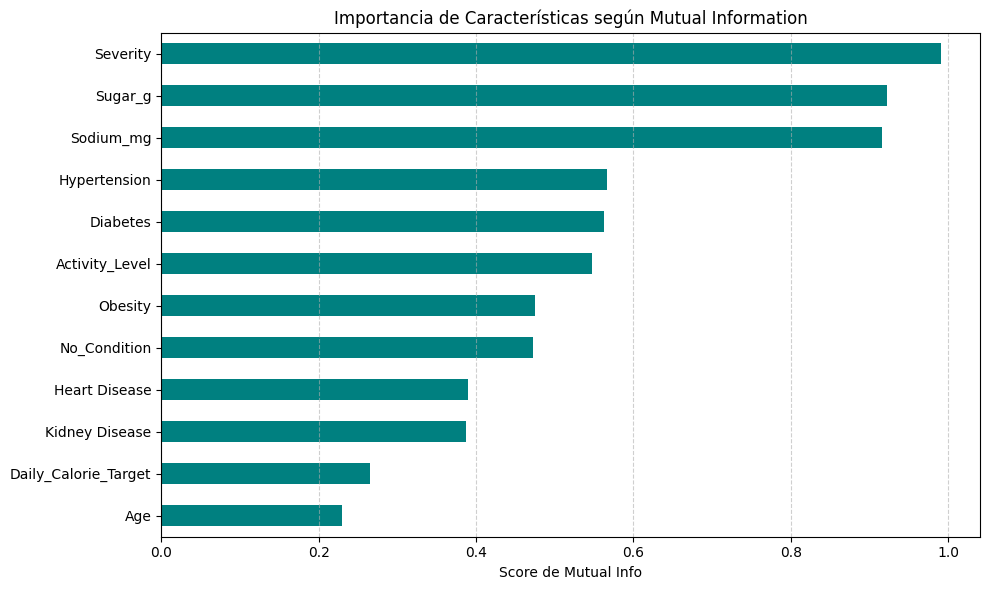


📊 Ranking de características:

Severity                0.9908
Sugar_g                 0.9227
Sodium_mg               0.9158
Hypertension            0.5669
Diabetes                0.5628
Activity_Level          0.5468
Obesity                 0.4747
No_Condition            0.4727
Heart Disease           0.3898
Kidney Disease          0.3873
Daily_Calorie_Target    0.2657
Age                     0.2301
dtype: float64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer

# ============================
# 1. Cargar dataset
# ============================
df = pd.read_csv("Generated_Medical_Diet_Dataset.csv")

# ============================
# 2. Preprocesamiento
# ============================
X = df.drop(columns=["Recommended_Meal_Plan_Medical"])
y = df["Recommended_Meal_Plan_Medical"]

# Imputar NaNs
X = pd.DataFrame(SimpleImputer(strategy="mean").fit_transform(X), columns=X.columns)

# ============================
# 3. Mutual Information
# ============================
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X, y)

# Ranking
mi_scores = pd.Series(mi_selector.scores_, index=X.columns).sort_values(ascending=True)

# ============================
# 4. Visualización
# ============================
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='barh', color='teal')
plt.title("Importancia de Características según Mutual Information")
plt.xlabel("Score de Mutual Info")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# (Opcional) Mostrar valores numéricos
print("\n📊 Ranking de características:\n")
print(mi_scores.sort_values(ascending=False).round(4))
